# Install Packages

In [ ]:
!pip install coclust
!pip install umap-learn
import nltk
nltk.download('stopwords')
nltk.download('punkt')
!pip install transformers
#!pip install gensim==4.1.1
!pip install hdbscan
nltk.download('wordnet')
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

#Import Libraries

In [2]:
#general libraries 
from tqdm import tqdm
import numpy as np
import requests
import warnings
import torch
import re,string,unicodedata
import pandas as pd
import os
import urllib.request
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from nltk import word_tokenize
# text representation 
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from scipy import spatial
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize,sent_tokenize
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
#Reduction de dimension et clustring
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from coclust.visualization import plot_confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.cluster import AgglomerativeClustering as CAH
import itertools
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.manifold import TSNE 
import hdbscan
from torch.utils.data import DataLoader
from rpy2.robjects.packages import importr
utils=importr("utils")

#Fonction utiles

In [3]:
import os
import math
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.cluster import KMeans
from tqdm import tqdm

"""
  Credits:
    This code is based on the implementation provided by Maziar Moradi Fard and Thibaut Thonet
    Available in: https://github.com/MaziarMF/deep-k-means
"""

TF_FLOAT_TYPE = tf.float32

tf.disable_eager_execution()

def fc_layers(input, specs):
    [dimensions, activations, names] = specs
    for dimension, activation, name in zip(dimensions, activations, names):
        input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)
    return input

def autoencoder(input, specs):
    [dimensions, activations, names] = specs
    mid_ind = int(len(dimensions)/2)

    # Encoder
    embedding = fc_layers(input, [dimensions[:mid_ind], activations[:mid_ind], names[:mid_ind]])
    # Decoder
    output = fc_layers(embedding, [dimensions[mid_ind:], activations[mid_ind:], names[mid_ind:]])

    return embedding, output

def f_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def g_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def next_batch(num, data):
    """
    Return a total of `num` random samples.
    """
    indices = np.arange(0, data.shape[0])
    np.random.shuffle(indices)
    indices = indices[:num]
    batch_data = np.asarray([data[i, :] for i in indices])

    return indices, batch_data

stopwords =set(stopwords.words('english'))
def clean_text(text):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(r'[0-9]+','',text)
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation
    text=' '.join([word for word in text.split() if word not in stopwords])

    return text
def tokenize_text(text, tokenizer, stopwords):
    wn=WordNetLemmatizer()
    tokens = tokenizer(text)  # Get tokens from text
    tokens = [wn.lemmatize(word).lower() for word in tokens]
    tokens = [t for t in tokens if len(t) > 2]  # Remove short tokens
    return tokens
def encode_sentences_batch(model, tokenizer, sentences, batch_size=32):
    n_layers = model.config.num_hidden_layers
    tokenized_sentences = [tokenizer.tokenize(sent)[:512] for sent in sentences]
    
    # sort by length
    argsort = np.argsort([len(i) for i in tokenized_sentences])
    sorted_inds = np.argsort(argsort)

    sentences = [sentences[i] for i in argsort]

    # sentences_dataset = BertDataset(sentences)
    data_loader = DataLoader(dataset=sentences,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=4,
                                collate_fn=lambda x: collate_fn(x, tokenizer)
                                )

    embeddings = {k:[] for k in range(n_layers)}

    for _, batch in enumerate(data_loader):
        with torch.no_grad():
            x, mask = batch
            x = x.to(device)

            output = model(x)
            hidden_states = output.hidden_states
            hidden_states = list(hidden_states[1:])

            for ind_layer, layer_embeddings in enumerate(hidden_states):
                # remove padding's zeros
                layer_embeddings = layer_embeddings.cpu() * mask[:, :, None]
                # compute average over tokens
                layer_hidden_state = layer_embeddings.mean(axis=1)

                embeddings[ind_layer].append(layer_hidden_state)

    # put the batches together and sort the documents
    embeddings = [torch.vstack(embeddings[layer_ind])[sorted_inds].numpy() for layer_ind in range(n_layers)]
    
    return embeddings
def collate_fn(batch_sentences, tokenizer):
    tokenized = tokenizer(batch_sentences, padding=True, truncation=True, max_length=512)
    inds = tokenized['input_ids']
    mask = tokenized['attention_mask']

    inds = torch.tensor(inds)
    mask = torch.tensor(mask)

    return inds, mask
def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            with tqdm(unit='B', unit_scale=True, unit_divisor=1024) as bar:
                for chunk in response.iter_content(CHUNK_SIZE):
                    if chunk:  # filter out keep-alive new chunks
                        f.write(chunk)
                        bar.update(CHUNK_SIZE)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)
def tokenize_re(text, min_len=2):
    tokens = token_pattern.findall(text)
    return [x for x in tokens if len(x) >= min_len]

def static_document_embeddings(word_embedding_func, docs, tokenizer, n_dims=300):
    """
        Given a set of tokenized sentences, compute the mean vector of w2v vectors for each sentence
    """
    doc_vectors = []
    for doc in docs:
        doc = tokenizer(doc)
        word_vectors = []
        for word in doc:
            vector = word_embedding_func(word)
            if vector is not None:
                word_vectors.append(vector)
        if word_vectors:
            doc_vector = np.array(word_vectors).mean(axis=0)
        else:
            warnings.warn("Zeros returned. Words not in vocabulary \"{}\"".format(doc), Warning)
            doc_vector = np.array([0] * n_dims)
        
        doc_vectors.append(doc_vector)
    return np.array(doc_vectors)    



In [4]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.embedding_dim)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.embedding_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.input_dim),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def autoencoder(X, embedding_dim, n_epochs=50, batch_size=64, learning_rate=1e-3, weight_decay=1e-8, seed=None, return_model=False):
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    if seed is not None:
      torch.manual_seed(seed)

    dataloader = DataLoader(dataset=X, batch_size=batch_size, shuffle=True)

    model = AutoEncoder(input_dim=X.shape[1], embedding_dim=embedding_dim)

    if device == 'cuda':
      model.cuda()

    loss_function = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate,
                                weight_decay=weight_decay)

    losses = []

    model.train()
    for epoch in tqdm(range(n_epochs)):
        for batch in dataloader:
          batch = batch.to(device)
          reconstructed = model(batch)
          
          loss = loss_function(reconstructed, batch)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          losses.append(loss)

    model.eval()
    tensor_X = torch.tensor(X)
    tensor_X = tensor_X.to(device)
    encoded_X = model.encoder(tensor_X)
    encoded_X = encoded_X.detach().cpu().numpy()

    if return_model:
      return encoded_X, model, losses
    else:
      return encoded_X


# Reading Data 

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [11]:
#**********BBC*********#
bbc=pd.read_csv("bbc.csv")
le.fit(bbc.label)
y_truebbc= le.transform(bbc.label)
set(y_truebbc)

{0, 1, 2, 3, 4}

In [12]:
#********Classic4*******#
C4=pd.read_csv("classic4.csv")
le.fit(C4.label)
y_truec4= le.transform(C4.label)
set(y_truec4)

{0, 1, 2, 3}

# Data Cleaning

In [13]:
#BBC
bbc['cleaned_text']=bbc["text"].map(lambda x:clean_text(x))
bbc["tokens"] = bbc["cleaned_text"].map(lambda x:tokenize_text(x, word_tokenize,stopwords))

In [14]:
#Classic4 
C4['cleaned_text']=C4["text"].map(lambda x:clean_text(x))
C4["tokens"] =C4["cleaned_text"].map(lambda x:tokenize_text(x, word_tokenize,stopwords))

#**Partie 1**

# Word2Vec

###Text Representation 

In [8]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' 
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz" 

--2021-12-05 14:21:20--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.235.40
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.235.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  44.9MB/s    in 36s     

2021-12-05 14:21:57 (43.6 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [15]:
from gensim.models import KeyedVectors 
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [16]:
get_w2v_vector = lambda x: word2vec[x] if x in  word2vec.vocab else None

In [17]:
token_pattern = r'(?u)\b\w\w+\b'
token_pattern = re.compile(token_pattern)

In [18]:
#Classic4
word2vec_c4 = static_document_embeddings(get_w2v_vector,C4.text,tokenize_re) 
#BBC 
word2vec_bbc = static_document_embeddings(get_w2v_vector,bbc.text,tokenize_re)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:179: Warning:

Zeros returned. Words not in vocabulary "['Neliac']"



##Clustering

In [19]:
word2vec_result_classic4=pd.DataFrame(columns=["method","NMI","ARI","ACCURACY"])
word2vec_result_bbc=pd.DataFrame(columns=["method","NMI","ARI","ACCURACY"])
def get_best_c4(X,y_true,y_pred):
  a=list(itertools.permutations(np.unique(y_pred)))
  cm=[]
  ac=[]
  y=[]
  y_pred = pd.Series(y_pred)
  for s in range(len(a)):
    i,j,k,l=a[s]
    y_p=y_pred.replace({0:i, 1:j, 2:k, 3:l})
    y.append(y_p)
    cm.append(confusion_matrix(y_true,y_p))
    ac.append(accuracy_score(y_true,y_p))
  max_v = max(ac)
  max_i = ac.index(max_v)
  plt.figure(figsize = (14,6))
  plt.suptitle('NMI = ' + str(NMI(y_true,y[max_i]))+'\nARI = ' + str(ARI(y_true,y[max_i]))+'\nACCURACY= ' + str(accuracy_score(y_true,y[max_i])))
  plt.subplot(1, 2, 1)
  plt.title("Preds")
  plt.scatter(x = X[:, 0], y = X[:, 1],c =y[max_i])
  plt.subplot(1, 2, 2)
  plt.title('True')
  plt.scatter(x = X[:, 0], y = X[:, 1],c =y_true)
  #plot_confusion_matrix(cm[max_i])
  del ac,cm,y_p
  return NMI(y_true,y[max_i]),ARI(y_true,y[max_i]),accuracy_score(y_true,y[max_i])
def get_best_bbc(X,y_true,y_pred):
  a=list(itertools.permutations(np.unique(y_pred)))
  cm=[]
  ac=[]
  y=[]
  y_pred = pd.Series(y_pred)
  for s in range(len(a)):
    i,j,k,l,m=a[s]
    y_p=y_pred.replace({0:i, 1:j, 2:k, 3:l,4:m})
    y.append(y_p)
    cm.append(confusion_matrix(y_true,y_p))
    ac.append(accuracy_score(y_true,y_p))
  max_v = max(ac)
  max_i = ac.index(max_v)
  plt.figure(figsize = (14,6))
  plt.suptitle('NMI = ' + str(NMI(y_true,y[max_i]))+'\nARI = ' + str(ARI(y_true,y[max_i]))+'\nACCURACY= ' + str(accuracy_score(y_true,y[max_i])))
  plt.subplot(1, 2, 1)
  plt.title("Preds")
  plt.scatter(x = X[:, 0], y = X[:, 1],c =y[max_i])
  plt.subplot(1, 2, 2)
  plt.title('True')
  plt.scatter(x = X[:, 0], y = X[:, 1],c =y_true)
  #plot_confusion_matrix(cm[max_i])
  del ac,cm,y_p
  return NMI(y_true,y[max_i]),ARI(y_true,y[max_i]),accuracy_score(y_true,y[max_i])

### Espace origine + Kmeans

#### Classic4

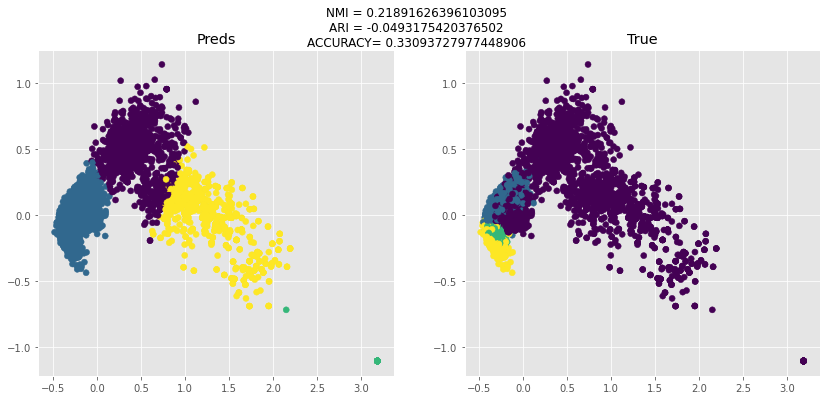

In [25]:
model = KMeans(n_clusters=4)
y_pred = model.fit_predict(word2vec_c4)
pca = PCA(n_components=2)
acp = pca.fit_transform(word2vec_c4)
nmi,ari,acc=get_best_c4(acp,y_truec4,y_pred)

In [26]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"Espace_origine+Kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

#### BBC

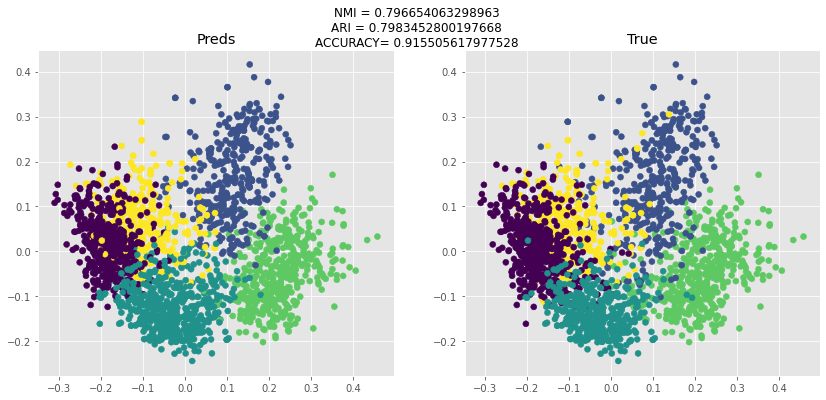

In [27]:
model = KMeans(n_clusters=5)
y_pred = model.fit_predict(word2vec_bbc)
pca = PCA(n_components=2)
acp = pca.fit_transform(word2vec_bbc)
nmi,ari,acc=get_best_bbc(acp,y_truebbc,y_pred)

In [28]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"Espace_origine+Kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### Espace Origine + CAH

#### Classic4

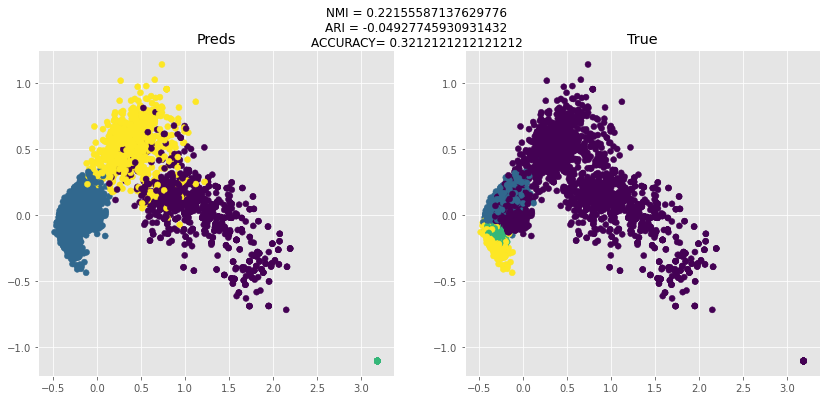

In [29]:
cah = CAH(n_clusters=4).fit(word2vec_c4)
y_pred=cah.labels_
pca = PCA(n_components=2)
acp = pca.fit_transform(word2vec_c4)
nmi,ari,acc=get_best_c4(acp,y_truec4,y_pred)

In [30]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"Espace_Origine+CAH","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)


#### BBC

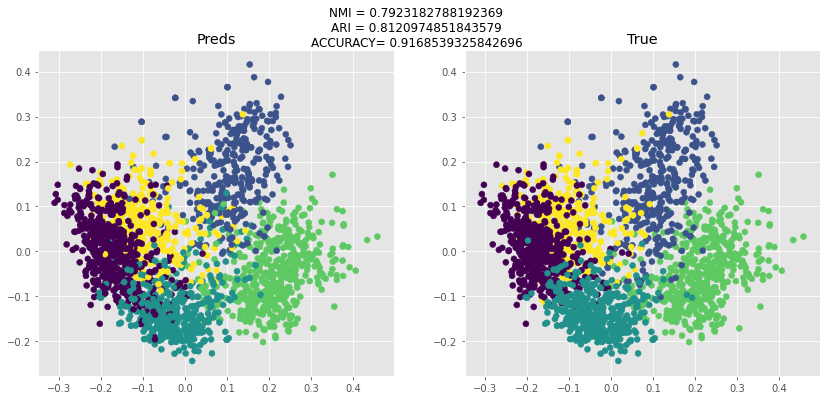

In [31]:
cah = CAH(n_clusters=5).fit(word2vec_bbc)
y_pred=cah.labels_
pca = PCA(n_components=2)
acp = pca.fit_transform(word2vec_bbc)
nmi,ari,acc=get_best_bbc(acp,y_truebbc,y_pred)

In [32]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"Espace_Origine+CAH","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### Espace origine + SpectralClustering

#### Classic4

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



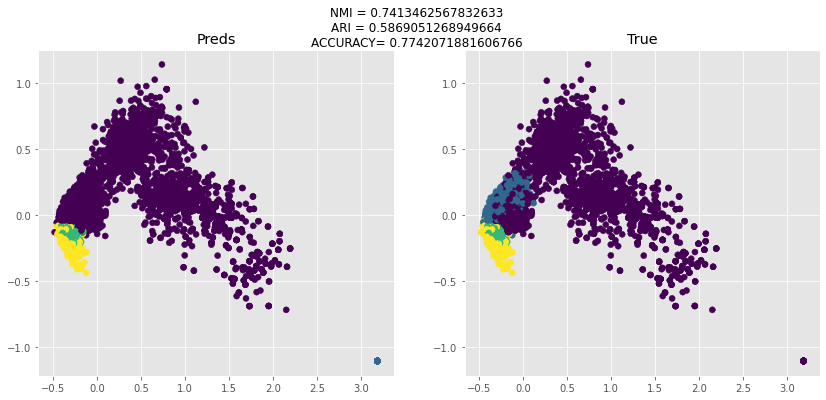

In [33]:
model = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42).fit(word2vec_c4)
y_pred = model.labels_
pca = PCA(n_components=2)
acp = pca.fit_transform(word2vec_c4)
nmi,ari,acc=get_best_c4(acp,y_truec4,y_pred)

In [34]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"Espace_origine+SpectralClustering","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

#### BBC

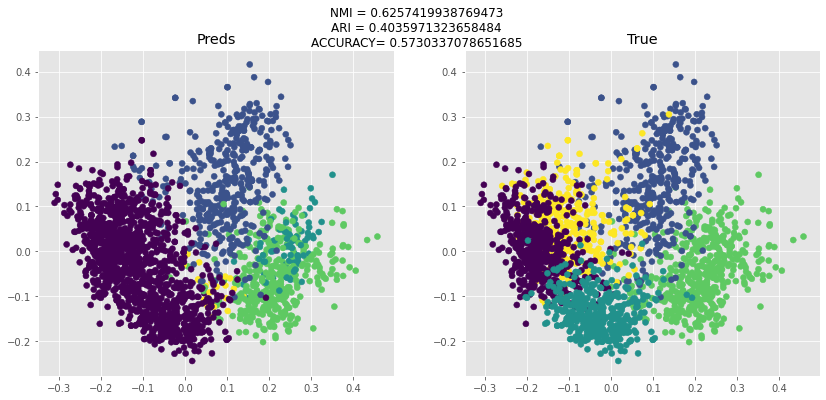

In [35]:
model = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42).fit(word2vec_bbc)
y_pred = model.labels_
pca = PCA(n_components=2)
acp = pca.fit_transform(word2vec_bbc)
nmi,ari,acc=get_best_bbc(acp,y_truebbc,y_pred)

In [36]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"Espace_Origine+SpectralClustering","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### ACP + Kmeans

#### Classic4

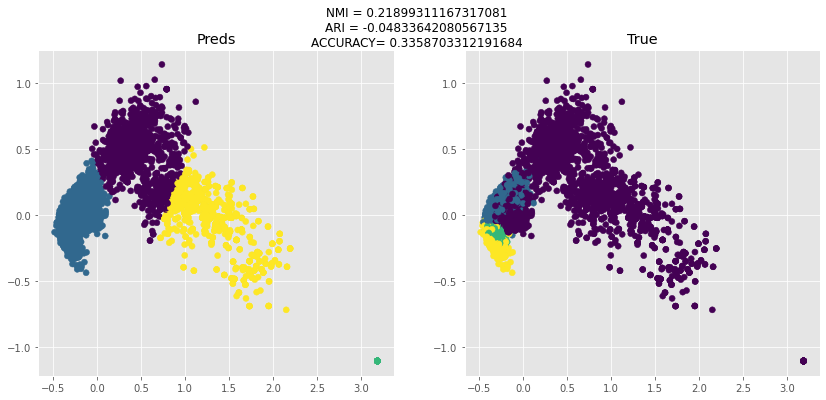

In [37]:
pca = PCA(n_components=2)
acp = pca.fit_transform(word2vec_c4)
model = KMeans(n_clusters=4)
y_pred = model.fit_predict(acp)
nmi,ari,acc=get_best_c4(acp,y_truec4,y_pred)

In [38]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"ACP+Kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

#### BBC

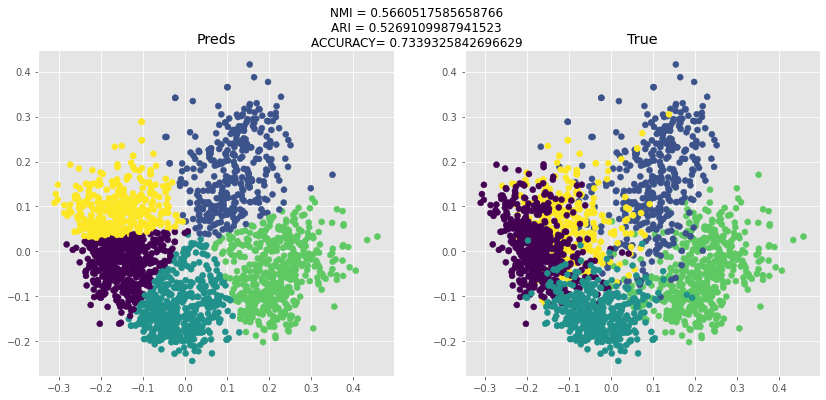

In [39]:
pca = PCA(n_components=2)
acp = pca.fit_transform(word2vec_bbc)
model = KMeans(n_clusters=5)
y_pred = model.fit_predict(acp)
nmi,ari,acc=get_best_bbc(acp,y_truebbc,y_pred)

In [40]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"ACP+Kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### ACP + CAH

#### Classic4

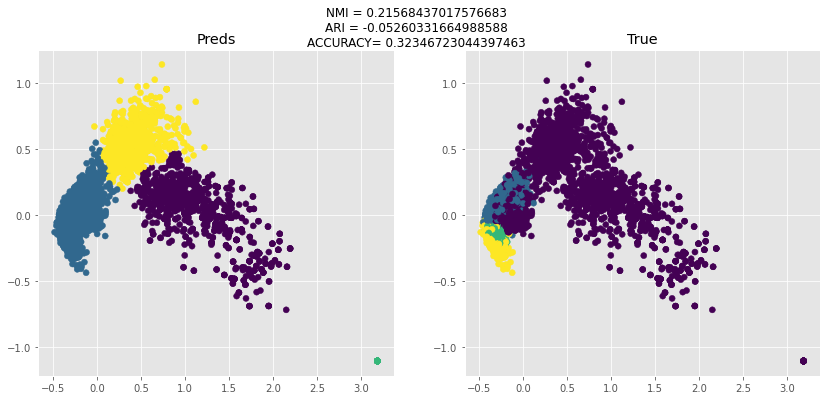

In [41]:
pca = PCA(n_components=2)
acp = pca.fit_transform(word2vec_c4)
cah = CAH(n_clusters=4).fit(acp)
y_pred=cah.labels_
nmi,ari,acc=get_best_c4(acp,y_truec4,y_pred)

In [42]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"ACP+CAH","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

#### BBC

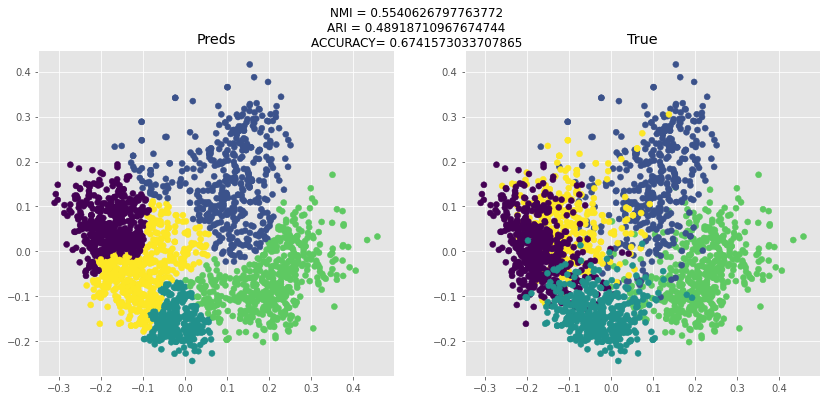

In [43]:
pca = PCA(n_components=2)
acp = pca.fit_transform(word2vec_bbc)
cah = CAH(n_clusters=5).fit(acp)
y_pred=cah.labels_
nmi,ari,acc=get_best_bbc(acp,y_truebbc,y_pred)

In [44]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"ACP+CAH","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### ACP + SpectralClustering

#### Classic4

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



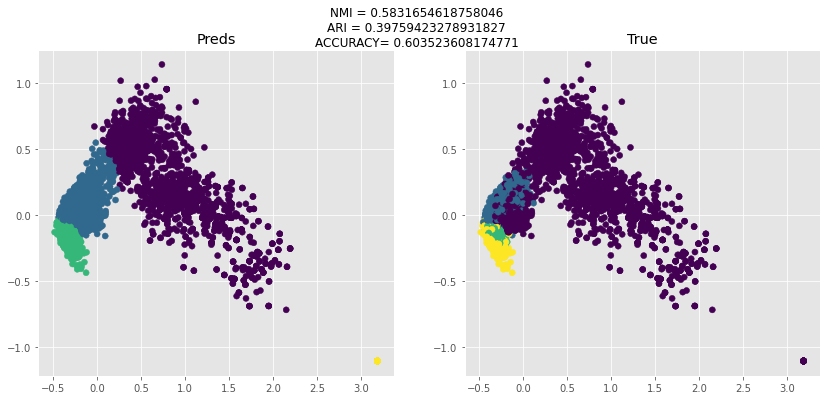

In [45]:
pca = PCA(n_components=2)
acp = pca.fit_transform(word2vec_c4)
model = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42).fit(acp)
y_pred = model.labels_
nmi,ari,acc=get_best_c4(acp,y_truec4,y_pred)

In [46]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"ACP+SpectralClustering","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

#### BBC

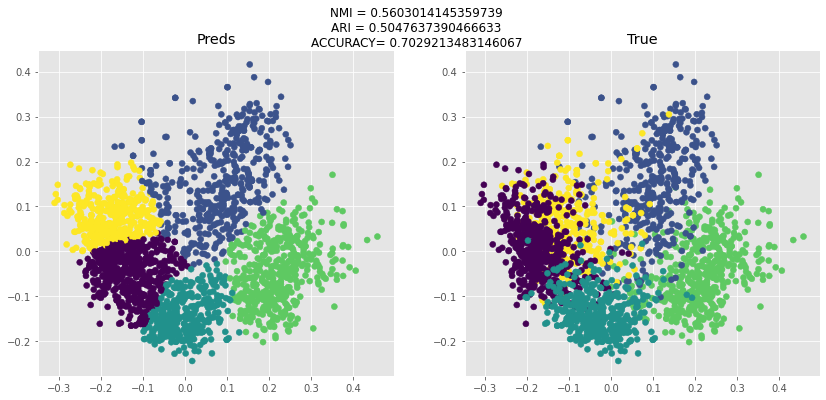

In [47]:
pca = PCA(n_components=2)
acp = pca.fit_transform(word2vec_bbc)
model = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42).fit(acp)
y_pred = model.labels_
nmi,ari,acc=get_best_bbc(acp,y_truebbc,y_pred)

In [48]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"ACP+SpectralClustering","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### TSNE + Kmeans

####Classic4

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



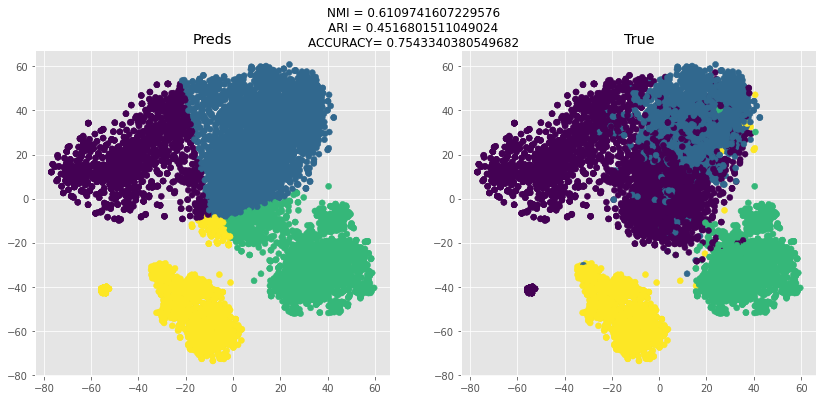

In [49]:
tsne = TSNE(n_components=2)
tsne = tsne.fit_transform(word2vec_c4)
model = KMeans(n_clusters =4)
y_pred = model.fit_predict(tsne)
nmi,ari,acc=get_best_c4(tsne,y_truec4,y_pred)

In [50]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"TSNE+Kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

####BBC

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



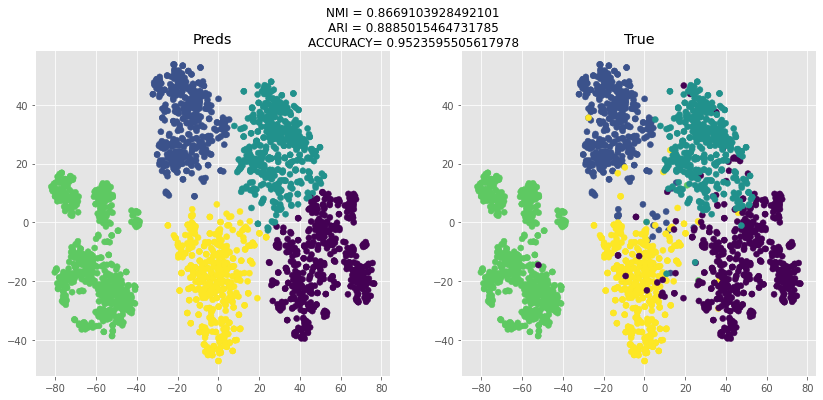

In [51]:
tsne = TSNE(n_components=2)
tsne = tsne.fit_transform(word2vec_bbc)
model = KMeans(n_clusters =5)
y_pred = model.fit_predict(tsne)
nmi,ari,acc=get_best_bbc(tsne,y_truebbc,y_pred)

In [52]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"TSNE+Kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### TSNE + CAH

####Classic4

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



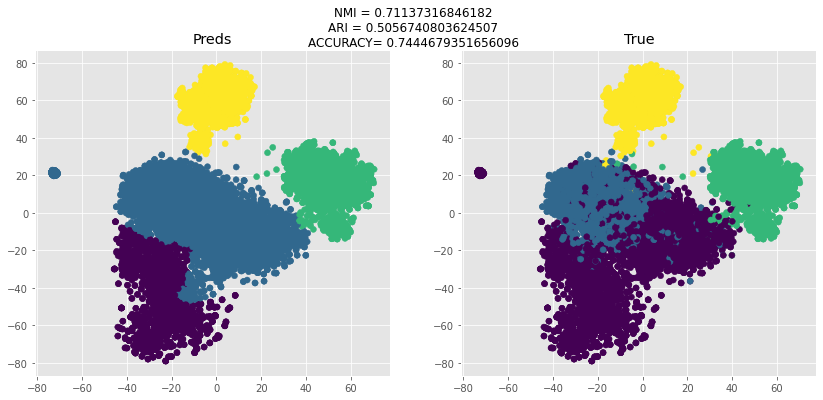

In [53]:
tsne = TSNE(n_components=2)
tsne = tsne.fit_transform(word2vec_c4)
model = CAH(n_clusters =4).fit(tsne)
y_pred = model.fit_predict(tsne)
nmi,ari,acc=get_best_c4(tsne,y_truec4,y_pred)

In [54]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"TSNE+CAH","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

####BBC

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



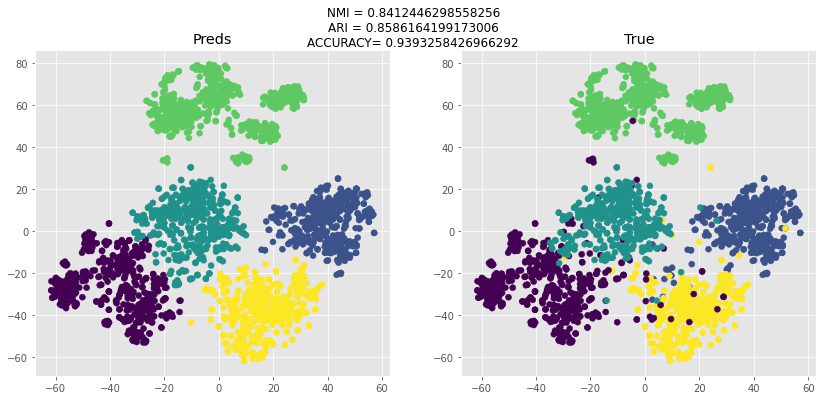

In [55]:
tsne = TSNE(n_components=2)
tsne = tsne.fit_transform(word2vec_bbc)
model = CAH(n_clusters =5).fit(tsne)
y_pred = model.fit_predict(tsne)
nmi,ari,acc=get_best_bbc(tsne,y_truebbc,y_pred)

In [56]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"TSNE+CAH","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### TSNE + SpectralClustering

####Classic4

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



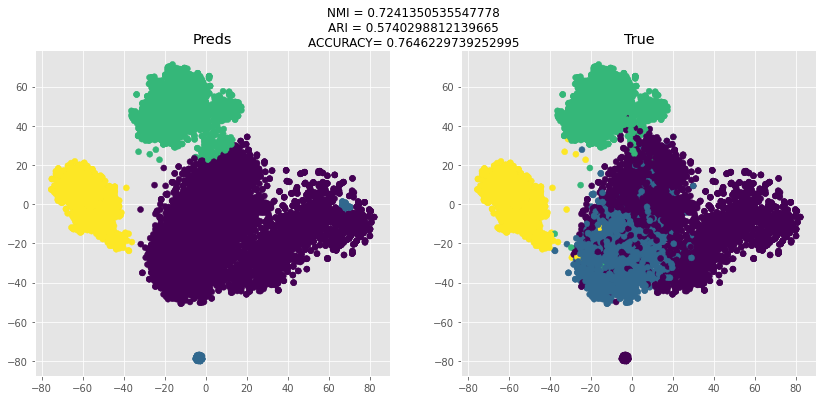

In [57]:
tsne = TSNE(n_components=2)
tsne = tsne.fit_transform(word2vec_c4)
model =  SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42).fit(tsne)
y_pred = model.fit_predict(tsne)
nmi,ari,acc=get_best_c4(tsne,y_truec4,y_pred)

In [58]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"TSNE+SpectralClustering","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

####BBC

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



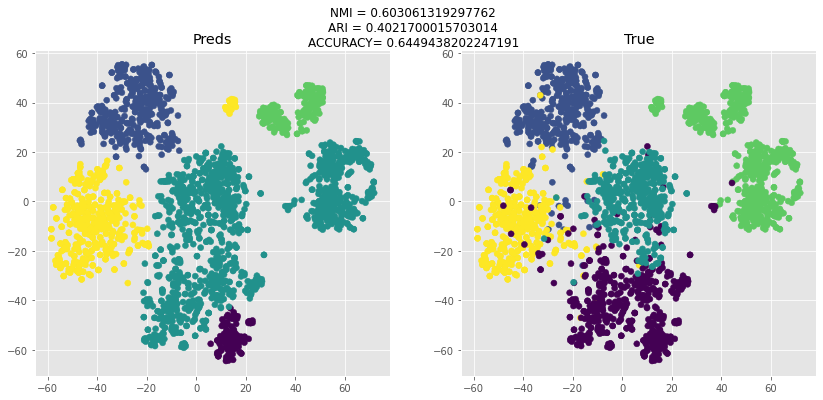

In [59]:
tsne = TSNE(n_components=2)
tsne = tsne.fit_transform(word2vec_bbc)
model =  SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42).fit(tsne)
y_pred = model.fit_predict(tsne)
nmi,ari,acc=get_best_bbc(tsne,y_truebbc,y_pred)

In [60]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"TSNE+SpectralClustering","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### UMAP + Kmeans 

####Classic4

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



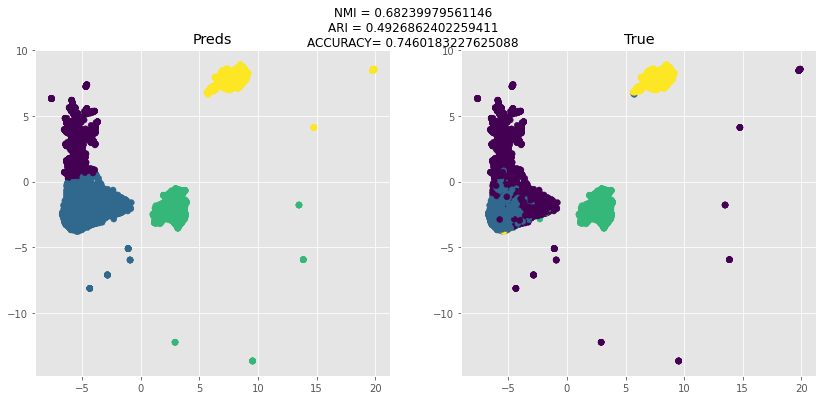

In [61]:
umap=UMAP(n_components=2).fit_transform(word2vec_c4)
model = KMeans(n_clusters =4)
y_pred = model.fit_predict(umap)
nmi,ari,acc=get_best_c4(umap,y_truec4,y_pred)

In [62]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"UMAP+kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

####BBC

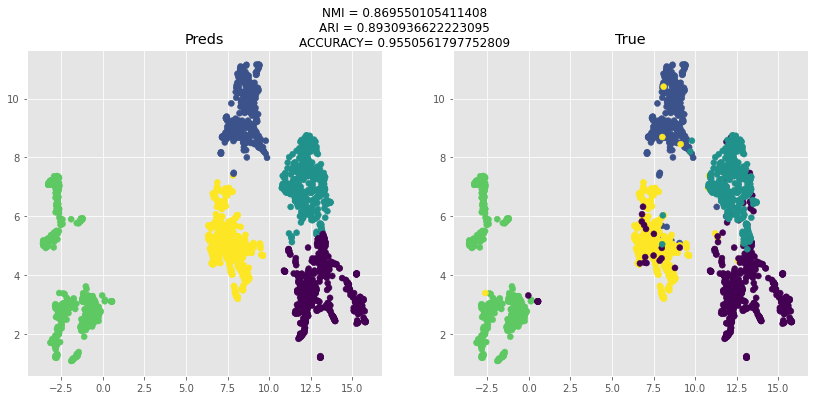

In [63]:
umap=UMAP(n_components=2).fit_transform(word2vec_bbc)
model = KMeans(n_clusters =5)
y_pred = model.fit_predict(umap)
nmi,ari,acc=get_best_bbc(umap,y_truebbc,y_pred)

In [64]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"UMAP+kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### UMAP + CAH

####Classic4

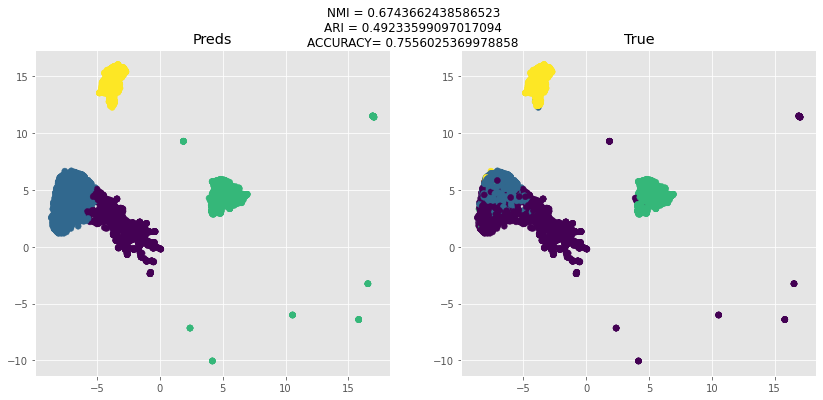

In [65]:
umap=UMAP(n_components=2).fit_transform(word2vec_c4)
model = CAH(n_clusters =4).fit(umap)
y_pred = model.fit_predict(umap)
nmi,ari,acc=get_best_c4(umap,y_truec4,y_pred)

In [66]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"UMAP+CAH","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

####BBC

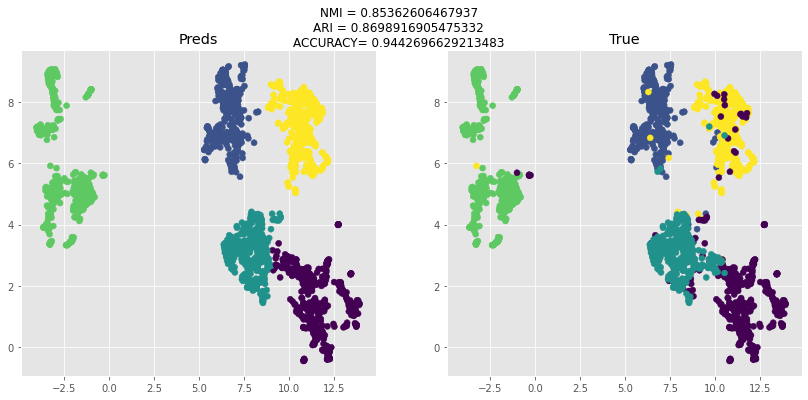

In [67]:
umap=UMAP(n_components=2).fit_transform(word2vec_bbc)
model = CAH(n_clusters =5).fit(umap)
y_pred = model.fit_predict(umap)
nmi,ari,acc=get_best_bbc(umap,y_truebbc,y_pred)

In [68]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"UMAP+CAH","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### UMAP + SpectralClustering

####Classic4

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



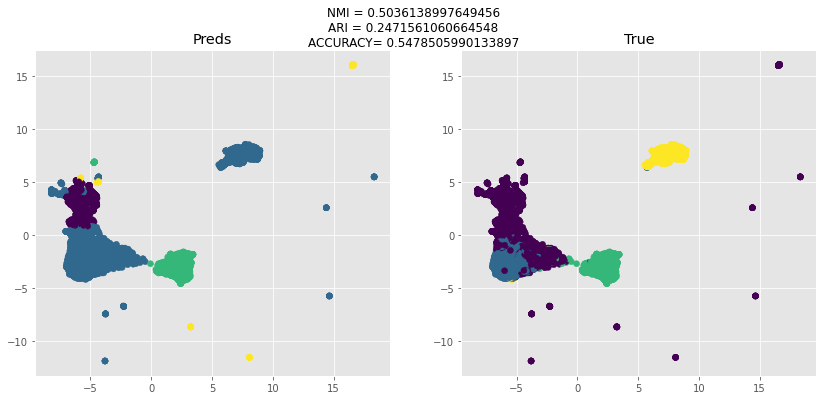

In [69]:
umap=UMAP(n_components=2).fit_transform(word2vec_c4)
model =  SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42).fit(umap)
y_pred = model.fit_predict(umap)
nmi,ari,acc=get_best_c4(umap,y_truec4,y_pred)

In [70]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"UMAP+SpectralClustering","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

####BBC

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



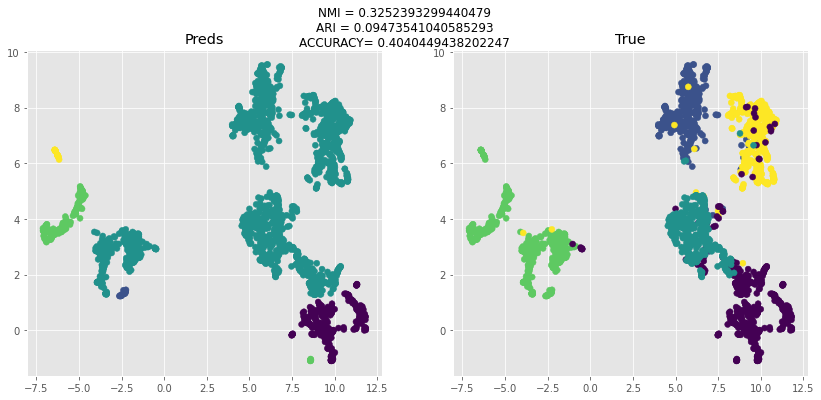

In [71]:
umap=UMAP(n_components=2).fit_transform(word2vec_bbc)
model =  SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42).fit(umap)
y_pred = model.fit_predict(umap)
nmi,ari,acc=get_best_bbc(umap,y_truebbc,y_pred)

In [72]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"UMAP+SpectralClustering","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### Autoencoder + kmeans

In [73]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.embedding_dim)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.embedding_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.input_dim),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def autoencoder(X, embedding_dim, n_epochs=50, batch_size=64, learning_rate=1e-3, weight_decay=1e-8, seed=None, return_model=False):
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    if seed is not None:
      torch.manual_seed(seed)

    dataloader = DataLoader(dataset=X, batch_size=batch_size, shuffle=True)

    model = AutoEncoder(input_dim=X.shape[1], embedding_dim=embedding_dim)

    if device == 'cuda':
      model.cuda()

    loss_function = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate,
                                weight_decay=weight_decay)

    losses = []

    model.train()
    for epoch in tqdm(range(n_epochs)):
        for batch in dataloader:
          batch = batch.to(device)
          reconstructed = model(batch)
          
          loss = loss_function(reconstructed, batch)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          losses.append(loss)

    model.eval()
    tensor_X = torch.tensor(X)
    tensor_X = tensor_X.to(device)
    encoded_X = model.encoder(tensor_X)
    encoded_X = encoded_X.detach().cpu().numpy()

    if return_model:
      return encoded_X, model, losses
    else:
      return encoded_X


#### Classic4

100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


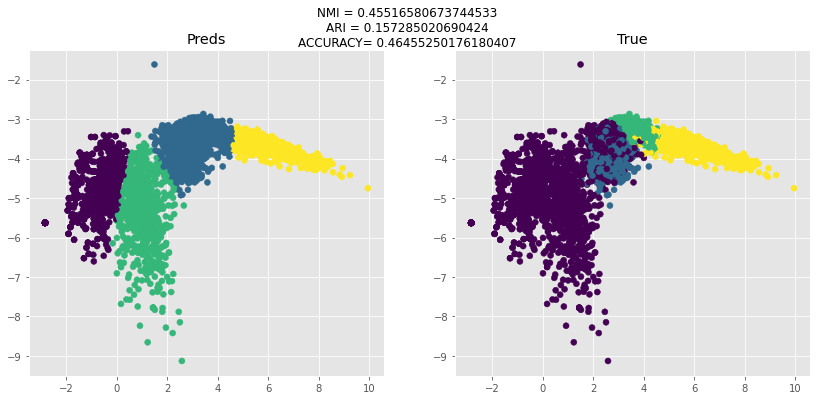

In [74]:
auto= autoencoder(word2vec_c4.astype("float32"),2, seed=42)
y_pred= KMeans(4,random_state=42).fit(auto).labels_
nmi,ari,acc=get_best_c4(auto,y_truec4,y_pred)

In [75]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"Autoencoder+Kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

#### BBC

100%|██████████| 50/50 [00:03<00:00, 13.73it/s]


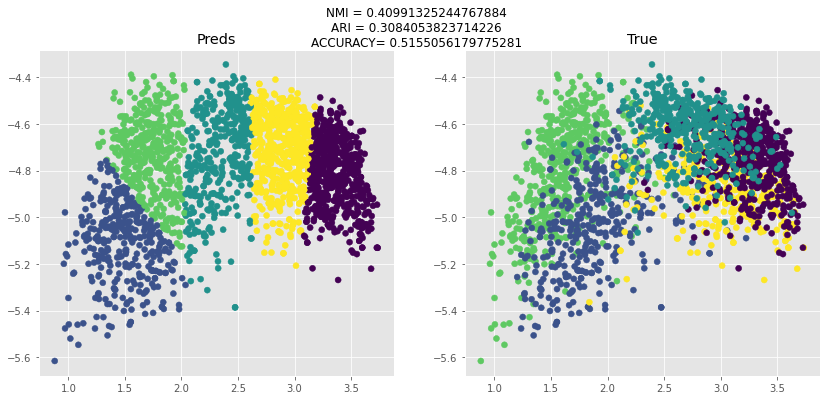

In [76]:
auto= autoencoder(word2vec_bbc.astype("float32"),2, seed=42)
y_pred= KMeans(5,random_state=42).fit(auto).labels_
nmi,ari,acc=get_best_bbc(auto,y_truebbc,y_pred)

In [77]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"Autoencoder+Kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### Autoencoder+CAH

#### Classic4

100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


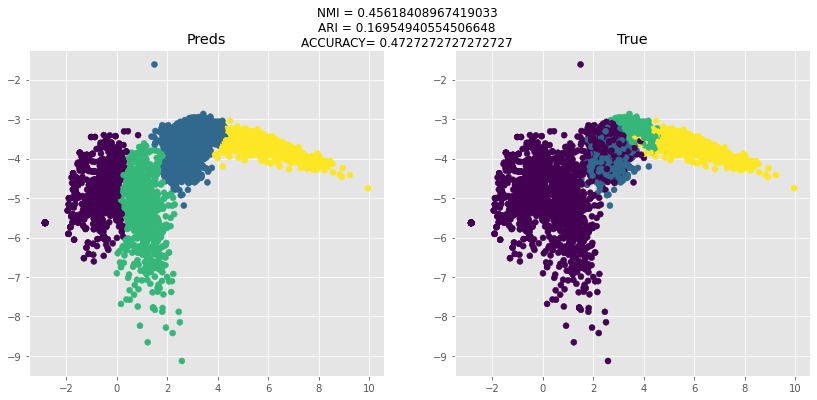

In [78]:
auto= autoencoder(word2vec_c4.astype("float32"),2, seed=42)
model = CAH(n_clusters =4).fit(auto)
y_pred = model.fit_predict(auto)
nmi,ari,acc=get_best_c4(auto,y_truec4,y_pred)

In [79]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"Autoencoder+CAH","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

#### BBC

100%|██████████| 50/50 [00:03<00:00, 13.51it/s]


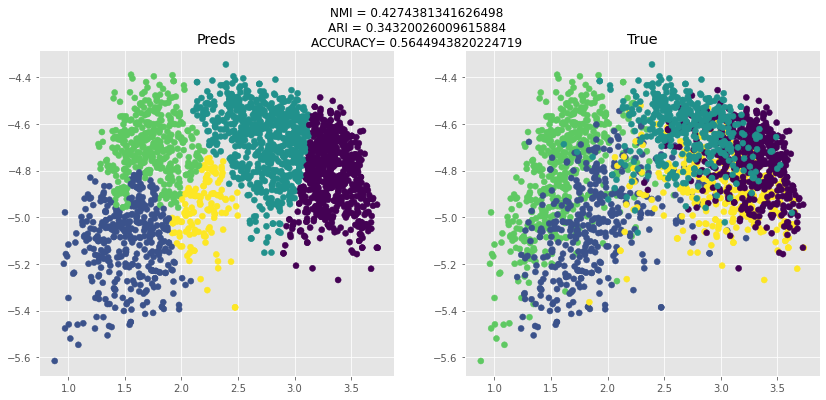

In [80]:
auto= autoencoder(word2vec_bbc.astype("float32"),2, seed=42)
model = CAH(n_clusters =5).fit(auto)
y_pred = model.fit_predict(auto)
nmi,ari,acc=get_best_bbc(auto,y_truebbc,y_pred)

In [81]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"Autoencoder+CAH","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### Autoencoder+SpectralClustering

#### Classic4

100%|██████████| 50/50 [00:11<00:00,  4.39it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



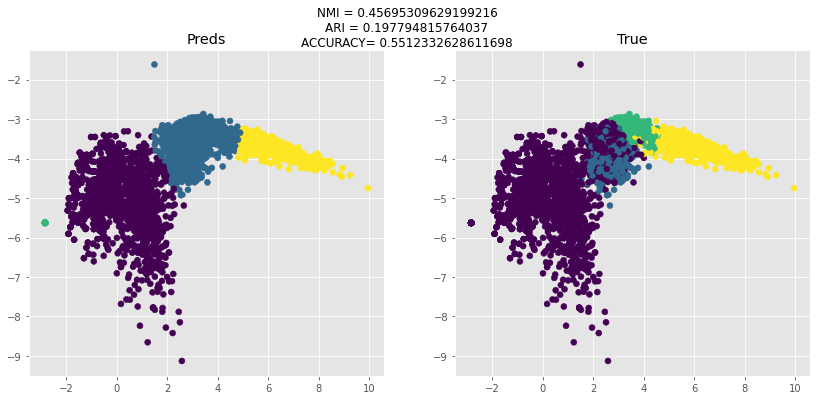

In [82]:
auto= autoencoder(word2vec_c4.astype("float32"),2, seed=42)
model =  SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42).fit(auto)
y_pred = model.fit_predict(auto)
nmi,ari,acc=get_best_c4(auto,y_truec4,y_pred)

In [83]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"Autoencoder+SpectralClustering","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

#### BBC

100%|██████████| 50/50 [00:03<00:00, 13.77it/s]


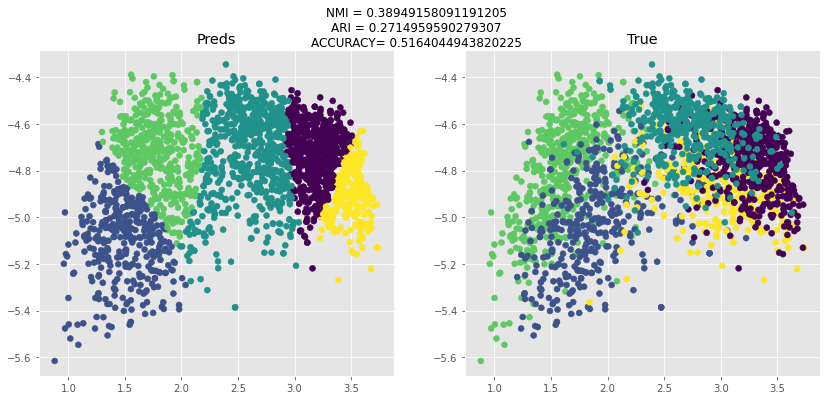

In [84]:
auto= autoencoder(word2vec_bbc.astype("float32"),2, seed=42)
model =  SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42).fit(auto)
y_pred = model.fit_predict(auto)
nmi,ari,acc=get_best_bbc(auto,y_truebbc,y_pred)

In [85]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"Autoencoder+SpectralClustering","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

#**Partie 2**

##Word2vec

### Reduced k-means

In [ ]:
utils.install_packages('FCPS',repos="https://cloud.r-project.org")

In [ ]:
utils.install_packages('clustrd',repos="https://cloud.r-project.org")

In [88]:
fcps=importr('FCPS')

####Classic4

R[write to console]: Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



  |======================================================================| 100%

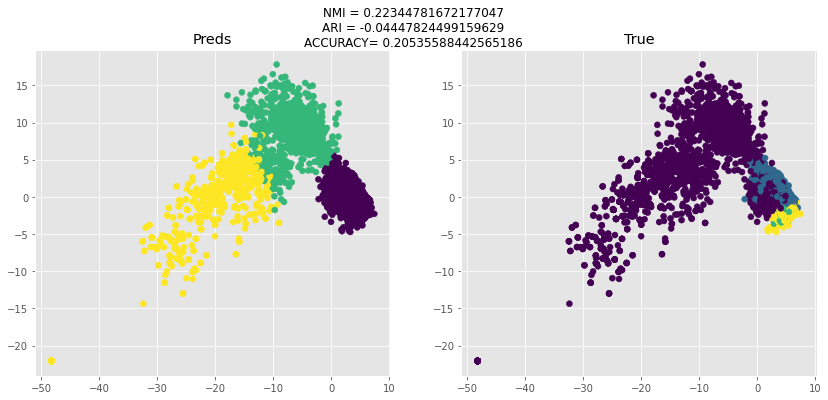

In [89]:
rkm=fcps.TandemClustering(word2vec_c4,4,Type='Reduced')
y_pred=rkm[0]
X_reduced=rkm[1][0]
nmi,ari,acc=get_best_c4(X_reduced,y_truec4,y_pred)

In [90]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"Reduced Kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

####BBC

  |======================================================================| 100%

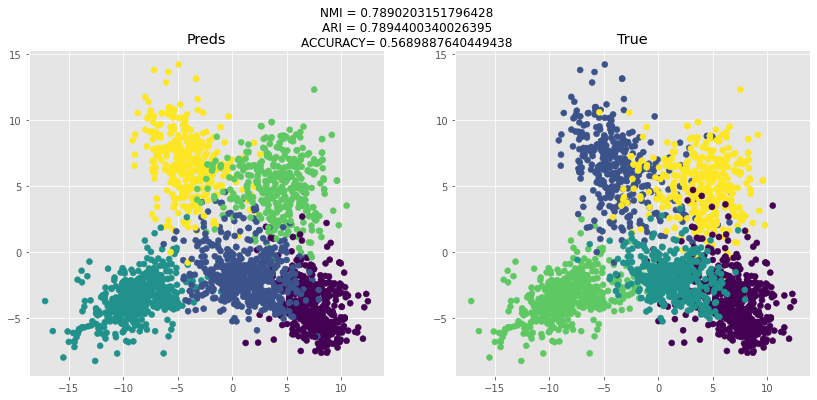

In [91]:
rkm=fcps.TandemClustering(word2vec_bbc,5,Type='Reduced')
y_pred=rkm[0]
X_reduced=rkm[1][0]
nmi,ari,acc=get_best_bbc(X_reduced,y_truebbc,y_pred)

In [93]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"Reduced Kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### Factorial Kmeans

#### Classic4

  |======================================================================| 100%

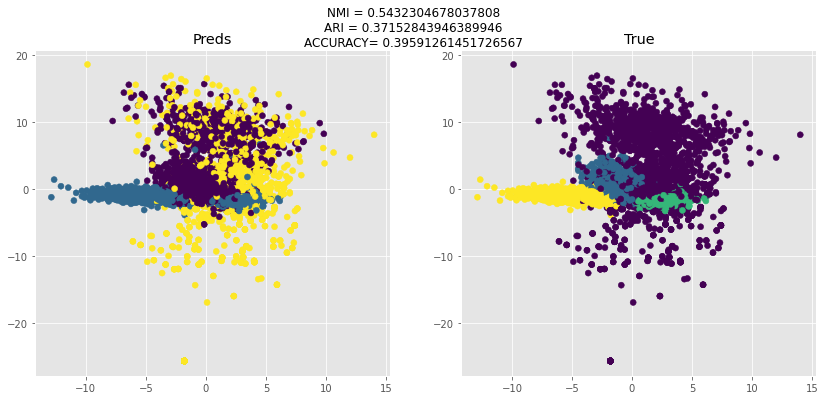

In [94]:
rkm=fcps.TandemClustering(word2vec_c4,4,Type='Factorial')
y_pred=rkm[0]
X_reduced=rkm[1][0]
nmi,ari,acc=get_best_c4(X_reduced,y_truec4,y_pred)

In [95]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"Factorial Kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

####BBC

  |======================================================================| 100%

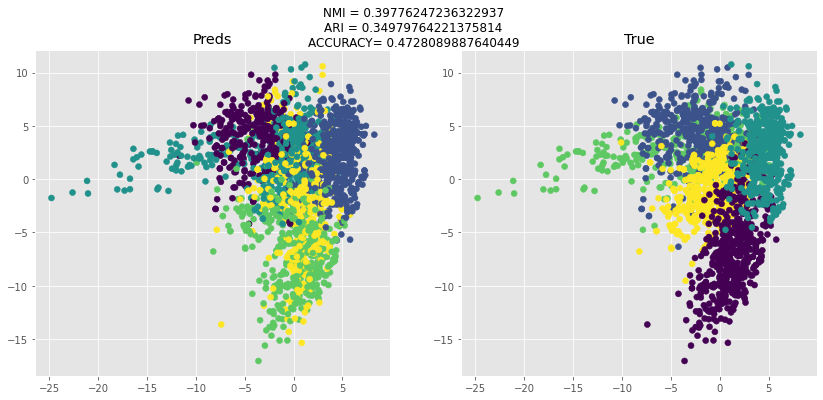

In [96]:
rkm=fcps.TandemClustering(word2vec_bbc,5,Type='Factorial')
y_pred=rkm[0]
X_reduced=rkm[1][0]
nmi,ari,acc=get_best_bbc(X_reduced,y_truebbc,y_pred)

In [97]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"Factorial Kmeans","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### Deep Clustring Network (DCN)

#### Fonction DCN

In [113]:
def fc_layers(input, specs):
    [dimensions, activations, names] = specs
    for dimension, activation, name in zip(dimensions, activations, names):
        input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)
    return input
def autoencoder(input, specs):
    [dimensions, activations, names] = specs
    mid_ind = int(len(dimensions)/2)
    embedding = fc_layers(input, [dimensions[:mid_ind], activations[:mid_ind], names[:mid_ind]])
    output = fc_layers(embedding, [dimensions[mid_ind:], activations[mid_ind:], names[mid_ind:]])
    return embedding, output
def f_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)
def g_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)
def next_batch(num, data):
    indices = np.arange(0, data.shape[0])
    np.random.shuffle(indices)
    indices = indices[:num]
    batch_data = np.asarray([data[i, :] for i in indices])
    return indices, batch_data

In [114]:
tf.disable_eager_execution()
class DcnCompGraph(object):
 
    def __init__(self, ae_specs, n_clusters, batch_size, n_samples, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0]) - 1) / 2)]
        self.input = tf.placeholder(dtype=tf.float32, shape=(batch_size, input_size))
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g
        self.ae_loss = tf.reduce_mean(rec_error)
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=tf.float32), name='cluster_rep', dtype=tf.float32)
        initial_clustering_assign = tf.random_uniform(minval=0, maxval=n_clusters, dtype=tf.int32, shape=[n_samples])
        self.cluster_assign = tf.Variable(initial_clustering_assign, name='cluster_assign', dtype=tf.int32, trainable=False)
        self.indices = tf.placeholder(dtype=tf.int32, shape=batch_size)  # Placeholder for sample indices in current batch
        batch_clust_rep = []
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            batch_clust_rep.append(self.cluster_rep[k, :])
        stack_batch_clust_rep = tf.stack(batch_clust_rep)
        clustering_error = f_func(self.embedding, stack_batch_clust_rep)
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(clustering_error)
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DCN
        self.train_op = optimizer.minimize(self.loss)
        for j in range(batch_size):
            # Find which cluster representative is the closest to the current batch sample
            new_assign = tf.argmin(f_func(tf.reshape(self.embedding[j, :], (1, embedding_size)), self.cluster_rep),
                                   output_type=tf.int32)
            # Update the clustering assignment
            self.cluster_assign_update = tf.assign(self.cluster_assign[self.indices[j]], new_assign)
        initial_count = tf.constant(100.0, shape=[n_clusters])
        count = tf.Variable(initial_count, name='count', dtype=tf.float32, trainable=False)
        ## Update the cluster representatives according to Equation (8) in the DCN paper
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            self.count_update = tf.assign(count[k], count[k] + 1)  # Updated count for cluster assignments
            new_rep = self.cluster_rep[k] - (1 / count[k]) * (self.cluster_rep[k] - self.embedding[j])
            self.cluster_rep_update = tf.assign(self.cluster_rep[k], new_rep)

In [115]:
tf.reset_default_graph()
def DCN(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=50, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names
    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True 

    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)
    cg = DcnCompGraph([dimensions, activations, names], n_clusters, batch_size, n_samples,
                      lambda_)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)
        if pretrain:
            print("Starting autoencoder pretraining...")
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)
            for _ in tqdm(range(n_pretrain_epochs)):
                for _ in range(n_batches):
                    indices_, data_batch = next_batch(batch_size, data)
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                       feed_dict={cg.input: data_batch})
                    for j in range(len(indices_)):
                        embeddings[indices_[j], :] = embedding_[j, :]
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))
            sess.run(tf.assign(cg.cluster_assign, kmeans_model.labels_))
        print("Starting DCN training...")
        for epoch in tqdm(range(n_finetuning_epochs)):
            for _ in range(n_batches):
                indices_, data_batch = next_batch(batch_size, data)
                _, _, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                    sess.run((cg.train_op, cg.cluster_assign_update, cg.count_update, cg.cluster_rep_update, cg.loss,
                              cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                             feed_dict={cg.input: data_batch, cg.indices: indices_})
        embeddings = np.zeros((n_samples, embedding_size), dtype=float)
        for _ in range(n_batches):
            indices_, data_batch = next_batch(batch_size, data)
            _, _, embeddings_, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                sess.run((cg.train_op, cg.cluster_assign_update, cg.embedding, cg.count_update, cg.cluster_rep_update, cg.loss, cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),feed_dict={cg.input: data_batch, cg.indices: indices_})
            for j in range(len(indices_)):
                embeddings[indices_[j], :] = embeddings_[j, :]
    return embeddings, cluster_assign_

#### Clustring

#####Clasic4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

`tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning:

`layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.



Starting autoencoder pretraining...


100%|██████████| 50/50 [02:01<00:00,  2.44s/it]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


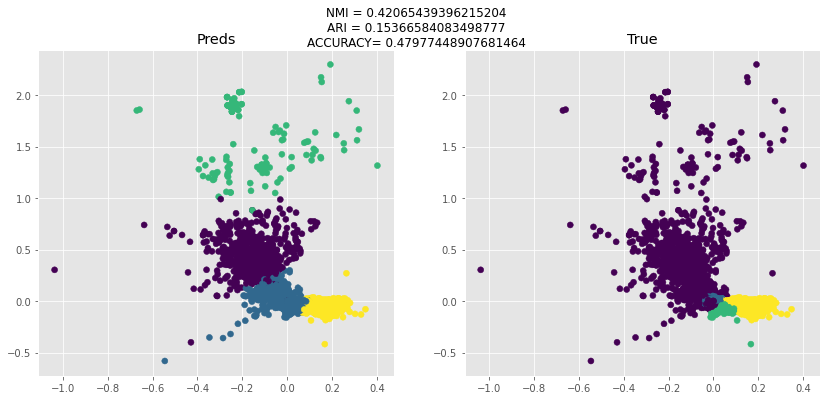

In [110]:
dcn,y_pred=DCN(word2vec_c4, 4, 2, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False)
nmi,ari,acc=get_best_c4(dcn,y_truec4,y_pred)

In [111]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"DCN","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

#####BBC

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

`tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning:

`layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.



Starting autoencoder pretraining...


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


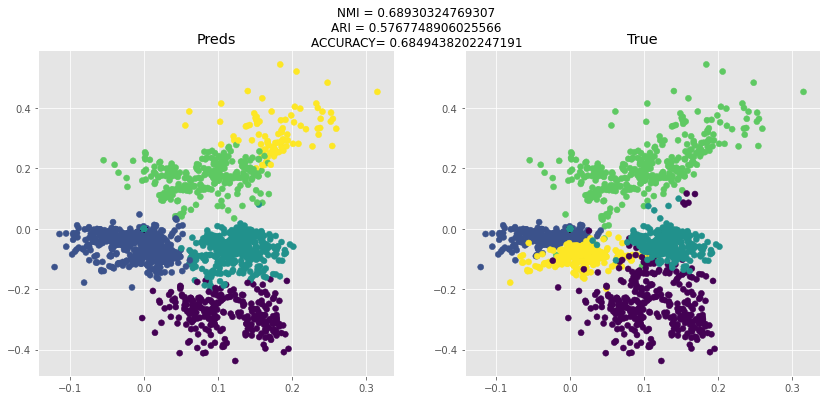

In [116]:
dcn,y_pred=DCN(word2vec_bbc, 5, 2, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False)
nmi,ari,acc=get_best_bbc(dcn,y_truebbc,y_pred)

In [121]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"DCN","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

### Deep K-means (DKM)

####Fonction DKM

In [123]:
tf.reset_default_graph()
TF_FLOAT_TYPE = tf.float32
class DkmCompGraph(object):
    """Computation graph for Deep K-Means
    """

    def __init__(self, ae_specs, n_clusters, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0])-1)/2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(None, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g

        # k-Means loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## First, compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, n_clusters):
            dist = f_func(self.embedding, tf.reshape(self.cluster_rep[i, :], (1, embedding_size)))
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        ## Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(list_dist, axis=0)

        ## Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        self.alpha = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=())  # Placeholder tensor for alpha
        list_exp = []
        for i in range(n_clusters):
            exp = tf.exp(-self.alpha * (self.stack_dist[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)

        ## Fourth, compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = self.stack_dist[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(tf.reduce_sum(stack_weighted_dist, axis=0))
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DKM
        self.train_op = optimizer.minimize(self.loss) # Train the whole DKM model

def DKM(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    """
        The final number of finetuning epochs is n_finetuning_epochs * 20 if pretrain and n_finetuning_epochs * 40 if annealing
    """
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained
    annealing = False # Specify if annealing should be used

    # Define the alpha scheme depending on if the approach includes annealing/pretraining
    if annealing and not pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 40  # Number of alpha values to consider
        alphas = np.zeros(max_n, dtype=float)
        alphas[0] = 0.1
        for i in range(1, max_n):
            alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
        alphas = alphas / constant_value
    elif not annealing and pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 20  # Number of alpha values to consider (constant values are used here)
        alphas = 1000*np.ones(max_n, dtype=float) # alpha is constant
        alphas = alphas / constant_value
    else:
        raise Exception("Run with either annealing (-a) or pretraining (-p), but not both.")

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    config = tf.ConfigProto(gpu_options=gpu_options)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)
      
    # Define the computation graph for DKM
    cg = DkmCompGraph([dimensions, activations, names], n_clusters, lambda_)

    # Run the computation graph
    with tf.Session(config=config) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Variables to save tensor content
        distances = np.zeros((n_clusters, n_samples))

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                        feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices)):
                        embeddings[indices[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DKM
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

        # Train the full DKM model
        if (len(alphas) > 0):
            print("Starting DKM training...")
        ## Loop over alpha (inverse temperature), from small to large values
        for k in tqdm(range(len(alphas))):
            # Loop over epochs per alpha
            for _ in range(n_finetuning_epochs):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph on the data batch
                    _, loss_, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
                        sess.run((cg.train_op, cg.loss, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                                  feed_dict={cg.input: data_batch, cg.alpha: alphas[k]})

                    # Save the distances for batch samples
                    for j in range(len(indices)):
                        distances[:, indices[j]] = stack_dist_[:, j]

        _, loss_, X_reduced, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
        sess.run((cg.train_op, cg.loss, cg.embedding, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                  feed_dict={cg.input: data, cg.alpha: alphas[k]})

        distances = stack_dist_

        # Infer cluster assignments for all samples
        cluster_assign = np.zeros((n_samples), dtype=float)
        for i in range(n_samples):
            index_closest_cluster = np.argmin(distances[:, i])
            cluster_assign[i] = index_closest_cluster
        cluster_assign = cluster_assign.astype(np.int64)

    return X_reduced, cluster_assign

#### Clustring

#####Clasic4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

`tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning:

`layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.



Starting autoencoder pretraining...


100%|██████████| 50/50 [02:03<00:00,  2.47s/it]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [04:07<00:00, 12.38s/it]


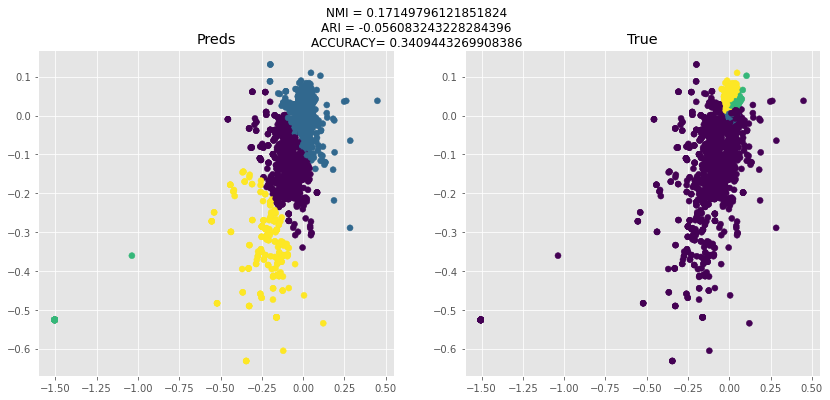

In [119]:
dkm,y_pred=DKM(word2vec_c4, 4, 2, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False)
nmi,ari,acc=get_best_c4(dkm,y_truec4,y_pred)

In [120]:
word2vec_result_classic4=word2vec_result_classic4.append({"method":"DKM","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

#####BBC

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

`tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning:

`layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.



Starting autoencoder pretraining...


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [01:19<00:00,  3.99s/it]


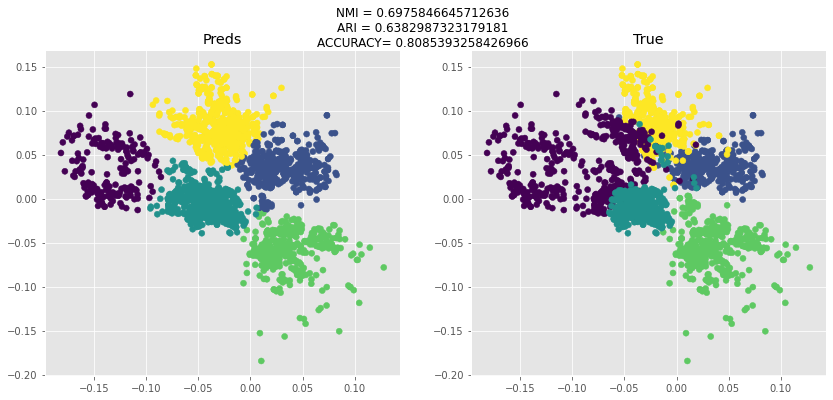

In [124]:
dkm,y_pred=DKM(word2vec_bbc, 5, 2, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False)
nmi,ari,acc=get_best_bbc(dkm,y_truebbc,y_pred)

In [125]:
word2vec_result_bbc=word2vec_result_bbc.append({"method":"DKM","NMI":nmi,"ARI":ari,"ACCURACY":acc},ignore_index=True)

In [126]:
word2vec_result_bbc.to_csv("word2vec_result_bbc.csv")
word2vec_result_classic4.to_csv("word2vec_result_classic4.csv")

In [127]:
word2vec_result_classic4

method       NMI       ARI  ACCURACY
0               Espace_origine+Kmeans  0.218916 -0.049318  0.330937
1                  Espace_Origine+CAH  0.221556 -0.049277  0.321212
2   Espace_origine+SpectralClustering  0.741346  0.586905  0.774207
3                          ACP+Kmeans  0.218993 -0.048336  0.335870
4                             ACP+CAH  0.215684 -0.052603  0.323467
5              ACP+SpectralClustering  0.583165  0.397594  0.603524
6                         TSNE+Kmeans  0.610974  0.451680  0.754334
7                            TSNE+CAH  0.711373  0.505674  0.744468
8             TSNE+SpectralClustering  0.724135  0.574030  0.764623
9                         UMAP+kmeans  0.682400  0.492686  0.746018
10                           UMAP+CAH  0.674366  0.492336  0.755603
11            UMAP+SpectralClustering  0.503614  0.247156  0.547851
12                 Autoencoder+Kmeans  0.455166  0.157285  0.464553
13                    Autoencoder+CAH  0.456184  0.169549  0.472727
14     Autoencoder+SpectralClustering  0.456953  0.197795  0.551233
15                     Reduced Kmeans  0.223448 -0.044478  0.205356
16                   Factorial Kmeans  0.543230  0.371528  0.395913
17                                DCN  0.420654  0.153666  0.479774
18                                DKM  0.171498 -0.056083  0.340944

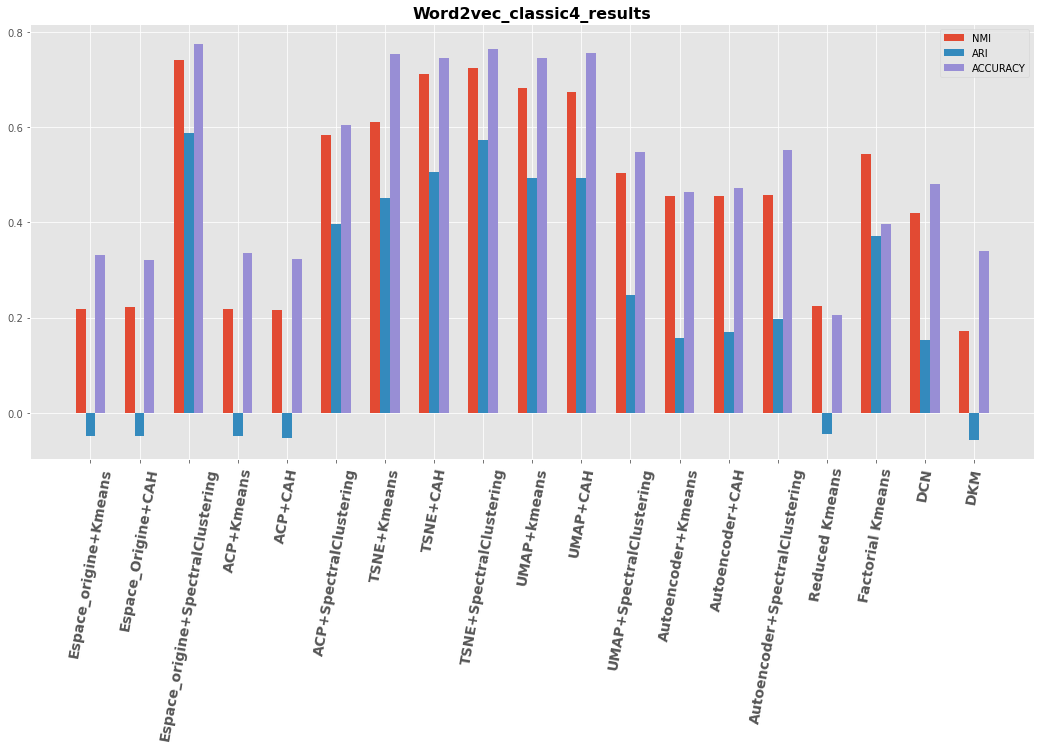

In [163]:
x =word2vec_result_classic4['method']
y =word2vec_result_classic4['NMI']
z = word2vec_result_classic4['ARI']
k = word2vec_result_classic4['ACCURACY']
X_axis = np.arange(len(x))
plt.figure(figsize=(18,8))
plt.bar(X_axis - 0.2,y, 0.2, label = 'NMI')
plt.bar(X_axis,z, 0.2, label = 'ARI')
plt.bar(X_axis + 0.2,k, 0.2, label = 'ACCURACY')  
plt.xticks(X_axis, x)
plt.xticks(rotation=80,weight='bold',fontsize=14)
plt.title("Word2vec_classic4_results",weight='bold',fontsize=16)
plt.legend()
plt.show()

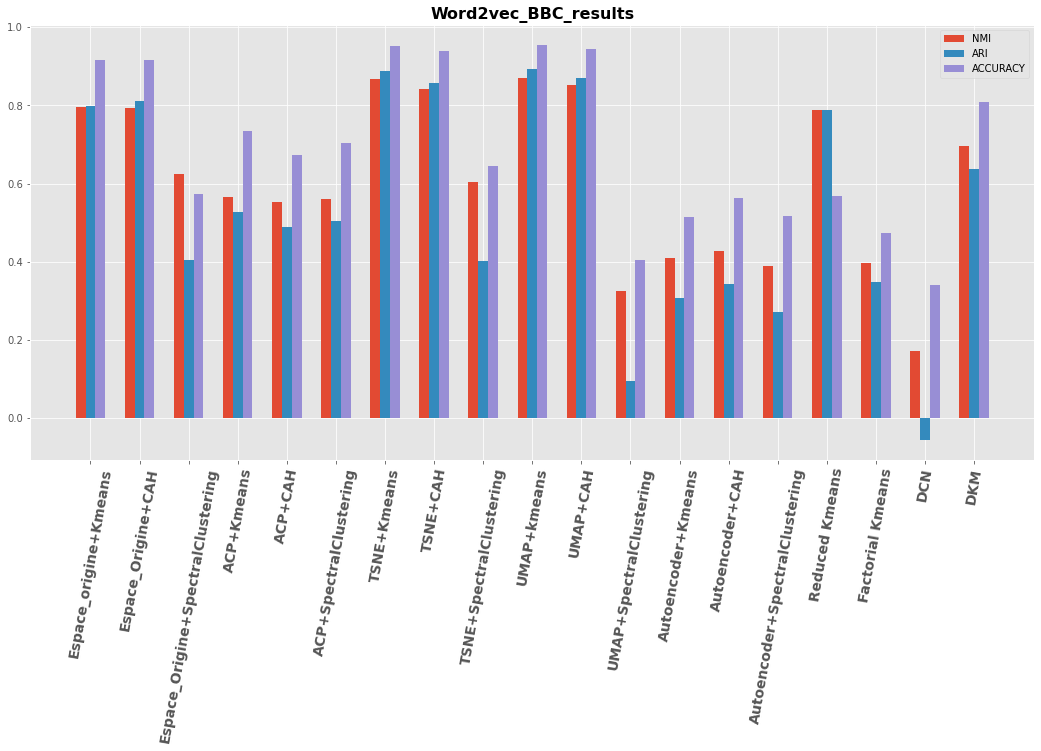

In [162]:
x =word2vec_result_bbc['method']
y =word2vec_result_bbc['NMI']
z = word2vec_result_bbc['ARI']
k = word2vec_result_bbc['ACCURACY']
X_axis = np.arange(len(x))
plt.figure(figsize=(18,8))
plt.bar(X_axis - 0.2,y, 0.2, label = 'NMI')
plt.bar(X_axis,z, 0.2, label = 'ARI')
plt.bar(X_axis + 0.2,k, 0.2, label = 'ACCURACY')  
plt.xticks(X_axis, x)
plt.xticks(rotation=80,weight='bold',fontsize=14)
plt.title("Word2vec_BBC_results",weight='bold',fontsize=16)
plt.legend()
plt.show()